<a href="https://colab.research.google.com/github/cesarinrc07-ship-it/Estad-stica2025B/blob/main/Tarea_TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar dataframe

# Importar dataframe si YF da error

In [2]:
pip install alpha_vantage

In [3]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = 'FOCULZQIJA8KBRBQ'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener
ticker = 'HSBC' # apple
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

# YYYY-mm-dd
inicio = '2023-07-20'
fin = '2025-07-20'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,HSBC_Open,HSBC_High,HSBC_Low,HSBC_Close,HSBC_Volume
date,,,,,
2025-07-18,63.07,63.155,62.735,62.82,1585119.0
2025-07-17,62.38,63.280,62.350,63.25,1247334.0
2025-07-16,62.33,62.600,62.040,62.54,2167879.0
2025-07-15,62.29,62.350,61.745,61.82,1346435.0
2025-07-14,62.21,62.540,62.160,62.51,1078386.0
...,...,...,...,...,...
2023-07-26,41.56,42.050,41.560,41.91,1501049.0
2023-07-25,41.55,41.670,41.445,41.54,1331398.0
2023-07-24,41.10,41.480,41.100,41.37,1082961.0


# Medias móviles

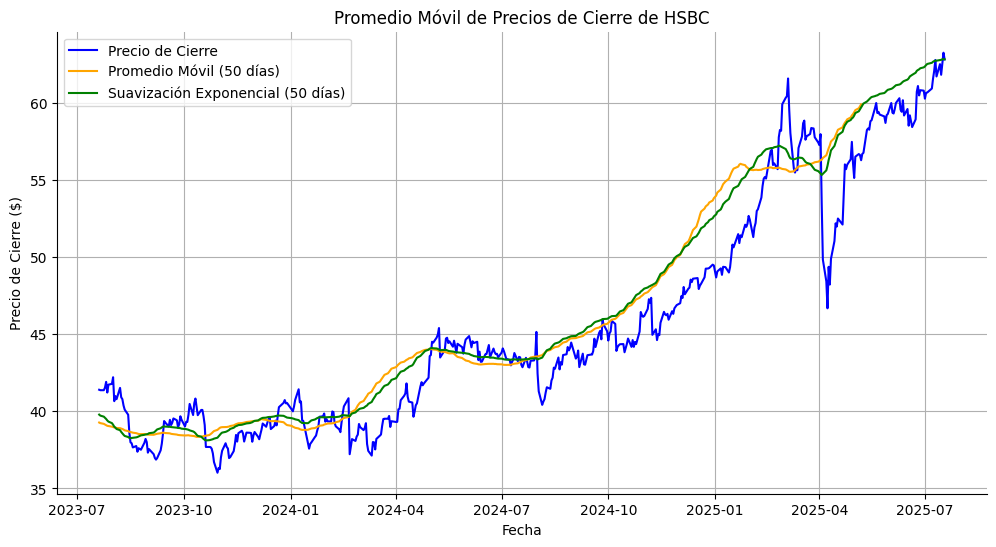

In [4]:
# Promedio Móvil Simple
ventana_sma = 50
df['SMA'] = df['HSBC_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['HSBC_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['HSBC_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de HSBC')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Prueba Dickey-Fuller Aumentada

In [5]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['HSBC_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -2.254370428893884
p-value: 0.18710676470303944
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Regresión polinomial

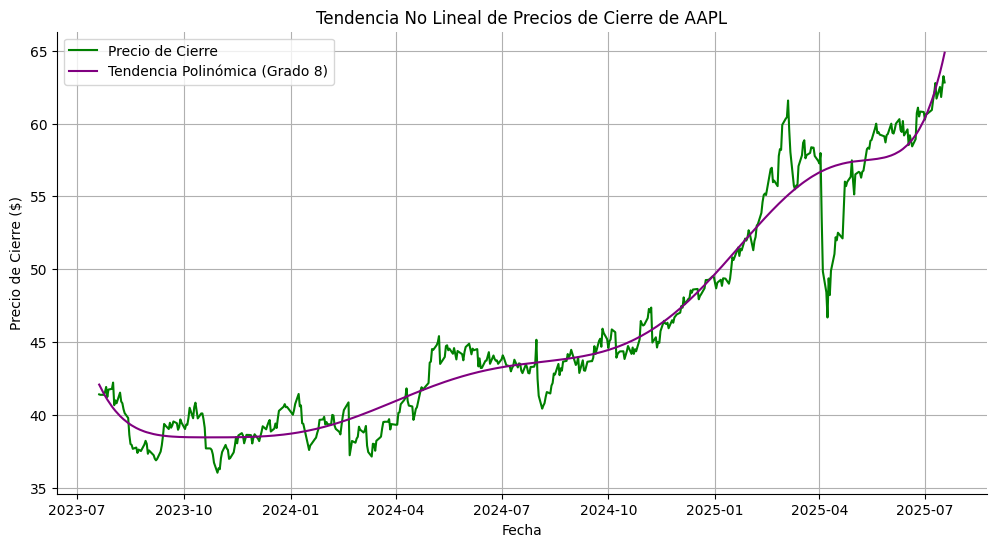

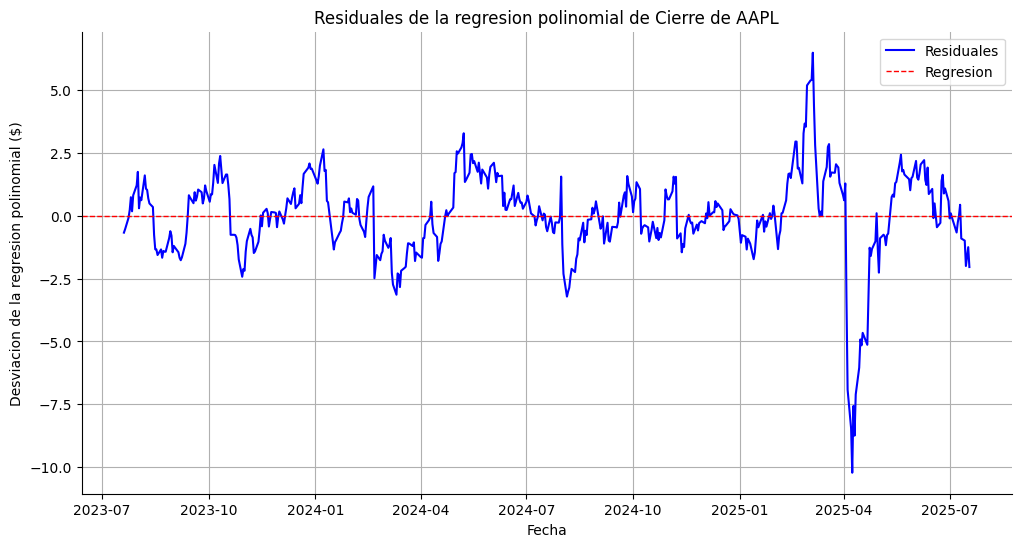

In [10]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date'] #siempre es la fecha
y = df['HSBC_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 8
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()